In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_87774/2310912846.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load binding data 

In [2]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
# train_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
# train_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
# test_x_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
# test_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")
# train_x = torch.from_numpy(train_x_df.to_numpy())
# train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
# test_x = torch.from_numpy(test_x_df.to_numpy())
# test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))

train_x_df = pd.read_csv(split_path+'bind/bind_train_x_ADASYN.csv')
train_y_df= pd.read_csv(split_path+'bind/bind_train_y_ADASYN.csv')
test_x_df= pd.read_csv(split_path+'bind/bind_test_x_ADASYN.csv')
test_y_df= pd.read_csv(split_path+'bind/bind_test_y_ADASYN.csv')

train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape



((2157, 306), (2157,), (282, 306), (282,))

# ADASYN

In [3]:
# # Scale data
# x_df = pd.concat([train_x_df, test_x_df])

# scaling=StandardScaler()
 
# # Use fit and transform method 
# scaling.fit(x_df)
# Scaled_data=scaling.transform(x_df)
# train_x = scaling.transform(train_x_df)
# test_x = scaling.transform(test_x_df) 

# adasyn = ADASYN() 
# train_x_temp, train_y_temp = adasyn.fit_resample(train_x, train_y_df)
# train_x = train_x_temp
# train_y = train_y_temp.to_numpy().flatten()
# test_y = test_y_df.to_numpy().flatten()

# # # back to df for saving 
# train_x_df = pd.DataFrame(train_x) 
# train_y_df = pd.DataFrame(train_y) 
# test_y_df = pd.DataFrame(test_y)
# test_x_df = pd.DataFrame(test_x)

# train_x_df.to_csv(split_path+'bind_train_x_ADASYN.csv', index=False, header=False)
# train_y_df.to_csv(split_path+'bind_train_y_ADASYN.csv', index=False, header=False) 
# test_y_df.to_csv(split_path+'bind_test_y_ADASYN.csv', index=False, header=False) 
# test_x_df.to_csv(split_path+'bind_test_x_ADASYN.csv', index=False, header=False) 


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.922, precision: 0.143, recall: 0.167, sensitivity: 0.167, specificity: 0.956


<Figure size 600x400 with 0 Axes>

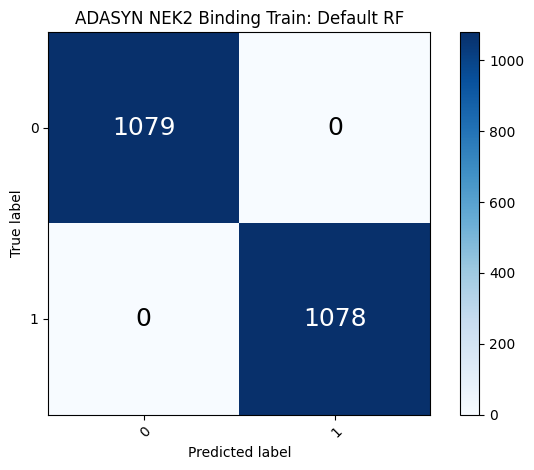

<Figure size 600x400 with 0 Axes>

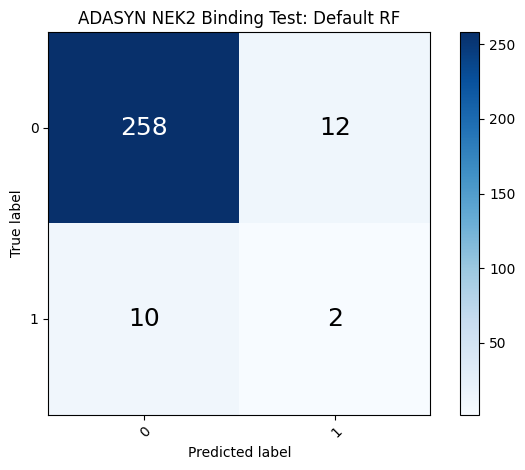

In [3]:
rf_basic100estADASYN= rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'binding')
plot_confusion_matrix(train_y, rf_basic100estADASYN['train_pred'], ['0','1'], title='ADASYN NEK2 Binding Train: Default RF')
plot_confusion_matrix(test_y, rf_basic100estADASYN['test_pred'], ['0','1'], title='ADASYN NEK2 Binding Test: Default RF')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [4]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [5]:
save_file = 'atom_nek2bindADASYN_rf_basic_best.pkl'
# rf_basicbestADASYN = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  save_file, 2)

TRAIN: accuracy: 0.991, precision: 0.999, recall: 0.982, sensitivity: 0.982, specificity: 0.999
TEST: accuracy: 0.922, precision: 0.222, recall: 0.333, sensitivity: 0.333, specificity: 0.948


<Figure size 600x400 with 0 Axes>

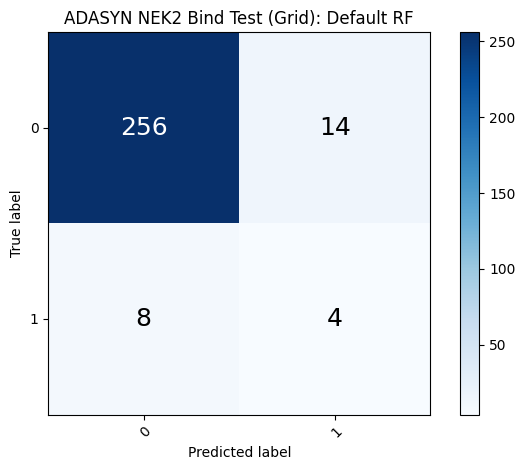

In [6]:
# with open(save_file, 'wb') as f:
#     pickle.dump(rf_basicbestADASYN['best_model'], f)

with open('saved_models/'+save_file, 'rb') as f: 
    rf_basicbestADASYN = pickle.load(f) 
gridresults1 = rf_results2(rf_basicbestADASYN, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridresults1['test_pred'], ['0','1'], title='ADASYN NEK2 Bind Test (Grid): Default RF')



In [17]:
for param, value in rf_basicbestADASYN.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 200
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 4
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 1050
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.915, precision: 0.167, recall: 0.250, sensitivity: 0.250, specificity: 0.944


<Figure size 600x400 with 0 Axes>

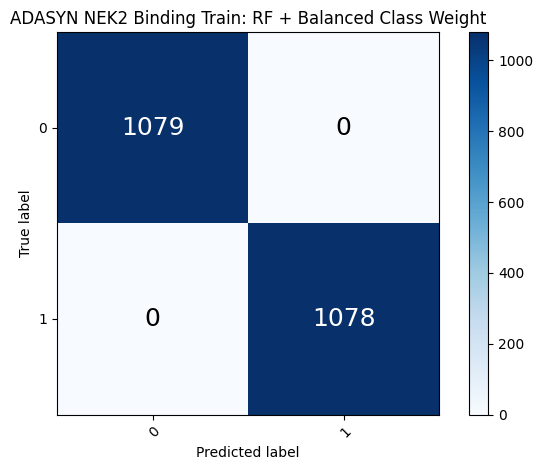

<Figure size 600x400 with 0 Axes>

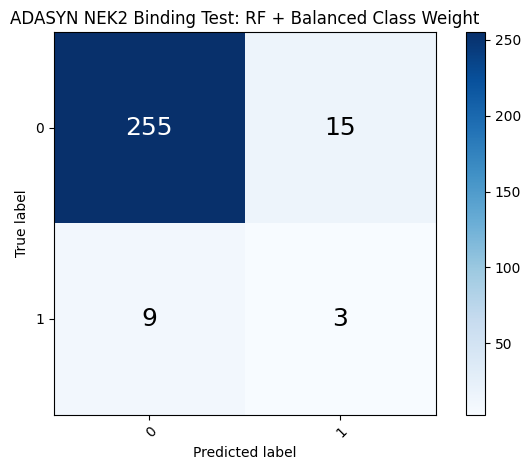

In [7]:
brf_model_BCW_ADASYN = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'binding')
plot_confusion_matrix(train_y, brf_model_BCW_ADASYN['train_pred'], ['0','1'], title='ADASYN NEK2 Binding Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW_ADASYN['test_pred'], ['0','1'], title='ADASYN NEK2 Binding Test: RF + Balanced Class Weight')

In [8]:
save_file2 = 'atom_nek2bindADASYN_rf_basicBCW_best.pkl'
# rf_basicBCWbestADASYN = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  save_file2, 2)
# with open(save_file2, 'rb') as f: 
#     rf_basicBCWbestADASYN = pickle.load(f) 


TRAIN: accuracy: 0.992, precision: 0.993, recall: 0.991, sensitivity: 0.991, specificity: 0.993
TEST: accuracy: 0.911, precision: 0.190, recall: 0.333, sensitivity: 0.333, specificity: 0.937


<Figure size 600x400 with 0 Axes>

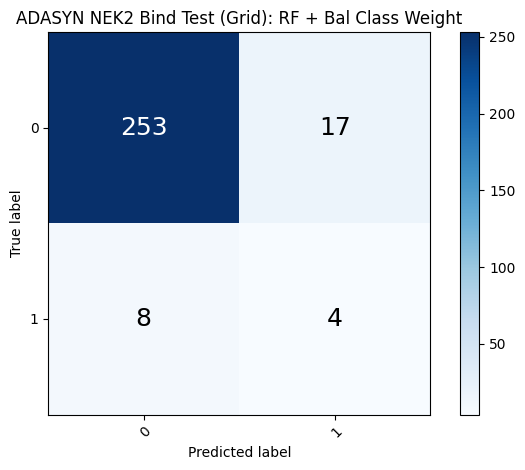

In [9]:
# with open(save_file2, 'wb') as f:
#     pickle.dump(rf_basicBCWbestADASYN['best_model'], f)


with open('saved_models/'+save_file2, 'rb') as f: 
    gridRF_BCW_ADASYN = pickle.load(f) 
gridresults2 = rf_results2(gridRF_BCW_ADASYN, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridresults2['test_pred'], ['0','1'], title='ADASYN NEK2 Bind Test (Grid): RF + Bal Class Weight')



In [14]:
for param,value in gridRF_BCW_ADASYN.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: 220
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


# Balanced Random Forest Classifier

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.922, precision: 0.143, recall: 0.167, sensitivity: 0.167, specificity: 0.956


<Figure size 600x400 with 0 Axes>

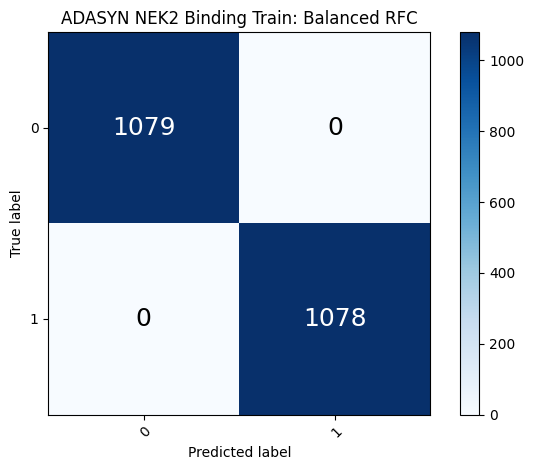

<Figure size 600x400 with 0 Axes>

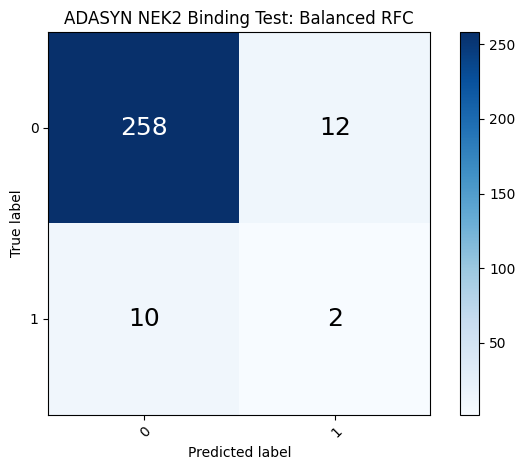

In [10]:
brf_modelADASYN = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, 'binding')
plot_confusion_matrix(train_y, brf_modelADASYN['train_pred'], ['0','1'], title='ADASYN NEK2 Binding Train: Balanced RFC')
plot_confusion_matrix(test_y, brf_modelADASYN['test_pred'], ['0','1'], title='ADASYN NEK2 Binding Test: Balanced RFC')

In [ ]:
# save_file3 = 'atom_nek2bindADASYN_BRFC_best.pkl'
# brfc_bestADASYN = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, param_grid,  save_file3, 2)



TRAIN: accuracy: 0.991, precision: 0.999, recall: 0.982, sensitivity: 0.982, specificity: 0.999
TEST: accuracy: 0.926, precision: 0.235, recall: 0.333, sensitivity: 0.333, specificity: 0.952


<Figure size 600x400 with 0 Axes>

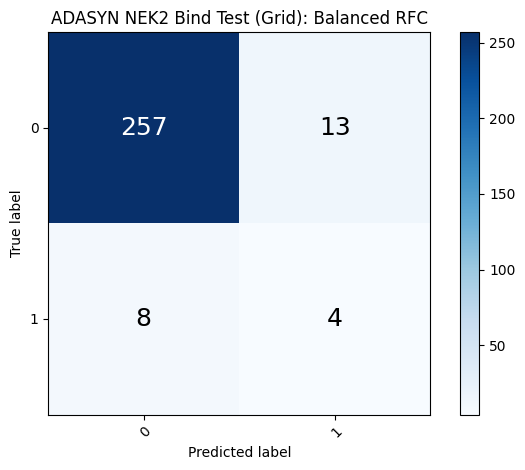

In [11]:
# with open(save_file3, 'wb') as f:
#     pickle.dump(brfc_bestADASYN['best_model'], f)
save_file3 = 'atom_nek2bindADASYN_BRFC_best.pkl'
with open('saved_models/'+save_file3, 'rb') as f: 
    brfc_bestADASYN = pickle.load(f) 

gridresults3 = rf_results2(brfc_bestADASYN, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridresults3['test_pred'], ['0','1'], title='ADASYN NEK2 Bind Test (Grid): Balanced RFC')



In [16]:
for param, value in brfc_bestADASYN.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 4
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


# Try BRFC with balanced class weight & bootstrap

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.918, precision: 0.176, recall: 0.250, sensitivity: 0.250, specificity: 0.948


<Figure size 600x400 with 0 Axes>

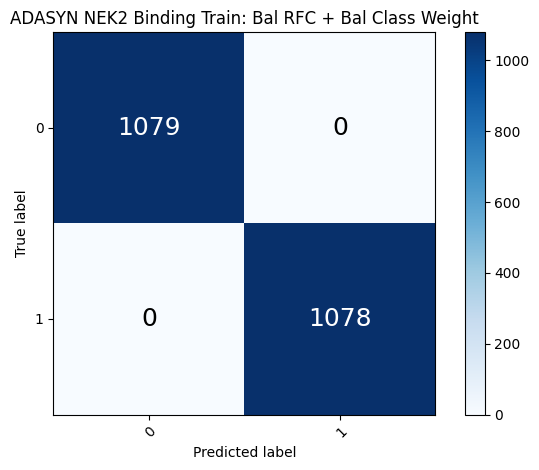

<Figure size 600x400 with 0 Axes>

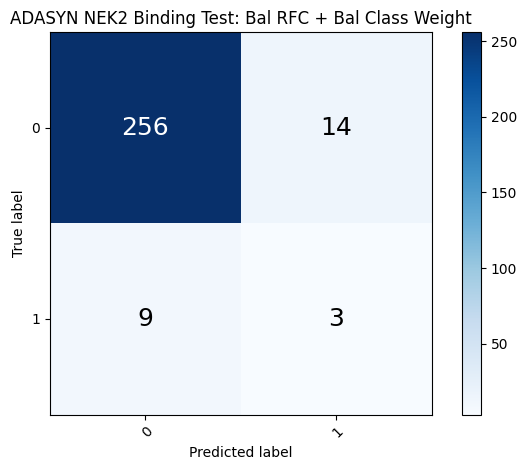

In [12]:
brf_modelCWB_ADASYN = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, 'binding')
plot_confusion_matrix(train_y, brf_modelCWB_ADASYN['train_pred'], ['0','1'], title='ADASYN NEK2 Binding Train: Bal RFC + Bal Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB_ADASYN['test_pred'], ['0','1'], title='ADASYN NEK2 Binding Test: Bal RFC + Bal Class Weight')

In [10]:
save_file4 = 'atom_nek2bindADASYN_BRFC_BCW_best.pkl'
# brfc_BCW_ADASYN_best = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, param_grid,  2,save_file4, 2)



TRAIN: accuracy: 0.994, precision: 0.998, recall: 0.990, sensitivity: 0.990, specificity: 0.998
TEST: accuracy: 0.926, precision: 0.200, recall: 0.250, sensitivity: 0.250, specificity: 0.956


<Figure size 600x400 with 0 Axes>

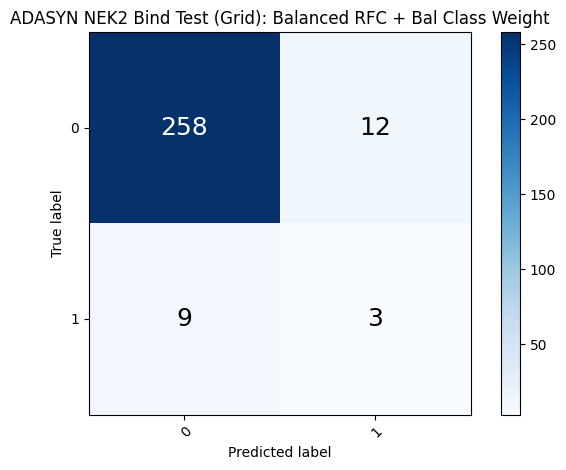

In [13]:
# with open(save_file4, 'wb') as f:
#     pickle.dump(brfc_BCW_ADASYN_best['best_model'], f)
save_file4 = 'atom_nek2bindADASYN_BRFC_BCW_best.pkl'
with open('saved_models/'+save_file4, 'rb') as f: 
    brfc_BCW_ADASYN_best = pickle.load(f) 

gridresults4 = rf_results2(brfc_BCW_ADASYN_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridresults4['test_pred'], ['0','1'], title='ADASYN NEK2 Bind Test (Grid): Balanced RFC + Bal Class Weight')



In [15]:
for param, value in brfc_BCW_ADASYN_best.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: entropy
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [18]:
# nek2bind_ADASYNmodels = {'default_RF':rf_basicbestADASYN, 'rf_bcw':gridRF_BCW_ADASYN,
#                               'BRFC':brfc_bestADASYN, 'BRFC_bcw':brfc_BCW_ADASYN_best}

# with open('nek2bind_ADASYNmodels.pkl', 'wb') as f:
#     pickle.dump(nek2bind_ADASYNmodels, f)


In [19]:
nek2bind_ADASYNmodels

{'default_RF': RandomForestClassifier(bootstrap=False, max_depth=200, max_features=None,
                        min_samples_leaf=2, min_samples_split=4,
                        n_estimators=1050),
 'rf_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=220,
                        max_features=None, min_samples_leaf=2),
 'BRFC': RandomForestClassifier(bootstrap=False, max_depth=100, max_features=None,
                        min_samples_leaf=2, min_samples_split=4),
 'BRFC_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced',
                        criterion='entropy', max_depth=100, max_features=None,
                        min_samples_leaf=2)}